In [14]:
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
df = pd.read_csv('Retail_Data_Transactions.csv')
print(df.head())
print(df.info())

  customer_id trans_date  tran_amount
0      CS5295  11-Feb-13           35
1      CS4768  15-Mar-15           39
2      CS2122  26-Feb-13           52
3      CS1217  16-Nov-11           99
4      CS1850  20-Nov-13           78
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB
None


In [16]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [17]:
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()
missing_values, duplicates

(customer_id    0
 trans_date     0
 tran_amount    0
 dtype: int64,
 6)

In [18]:
# Вычисляем Recency, Frequency и Monetary для каждого клиента
latest_date = df['trans_date'].max()
rfm_data = df.groupby('customer_id').agg({
    'trans_date': lambda x: (latest_date - x.max()).days,
    'customer_id': 'count',
    'tran_amount': 'sum'
}).rename(columns={'trans_date': 'Recency', 'customer_id': 'Frequency', 'tran_amount': 'Monetary'})
print(rfm_data.head())
print('*'*20)
print(rfm_data.describe())

             Recency  Frequency  Monetary
customer_id                              
CS1112            61         15      1012
CS1113            35         20      1490
CS1114            32         19      1432
CS1115            11         22      1659
CS1116           203         13       857
********************
           Recency    Frequency     Monetary
count  6889.000000  6889.000000  6889.000000
mean     80.538249    18.144869  1179.269705
std      85.382526     5.193014   465.832609
min       0.000000     4.000000   149.000000
25%      22.000000    14.000000   781.000000
50%      53.000000    18.000000  1227.000000
75%     111.000000    22.000000  1520.000000
max     857.000000    39.000000  2933.000000


In [19]:
#t-test
low_recency_group = rfm_data[rfm_data['Recency'] <= 53]['Frequency']
high_recency_group = rfm_data[rfm_data['Recency'] > 53]['Frequency']


t_statistic, p_value = stats.ttest_ind(low_recency_group, high_recency_group)


print(f"t-статистика: {t_statistic}")
print(f"p-значение: {p_value}")

alpha = 0.05  
if p_value < alpha:
    print("Существует статистически значимая разница в переменной Frequency между группами.")
else:
    print("Нет статистически значимой разницы в переменной Frequency между группами.")

t-статистика: 15.406833929185085
p-значение: 1.1060675509316575e-52
Существует статистически значимая разница в переменной Frequency между группами.


In [20]:
# Разделяем метрики на квантили
quantiles = rfm_data.quantile(q=[0.25, 0.5, 0.75])


# Создаем функцию для присвоения ранга каждой метрике
def r_score(x, column, quantiles):
    if x <= quantiles[column][0.25]:
        return 4
    elif x <= quantiles[column][0.50]:
        return 3
    elif x <= quantiles[column][0.75]:
        return 2
    else:
        return 1

def fm_score(x, column, quantiles):
    if x <= quantiles[column][0.25]:
        return 1
    elif x <= quantiles[column][0.50]:
        return 2
    elif x <= quantiles[column][0.75]:
        return 3
    else:
        return 4

# Применяем функции к датасету
rfm_data['R'] = rfm_data['Recency'].apply(r_score, args=('Recency', quantiles))
rfm_data['F'] = rfm_data['Frequency'].apply(fm_score, args=('Frequency', quantiles))
rfm_data['M'] = rfm_data['Monetary'].apply(fm_score, args=('Monetary', quantiles))

# Создаем сегменты клиентов
rfm_data['RFM_Segment'] = rfm_data['R'].astype(str) + rfm_data['F'].astype(str) + rfm_data['M'].astype(str)
rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)

# Определяем лейблы для клиентов
def get_label(x):
    if x >= 9:
        return 'Champion'
    elif x >= 8:
        return 'Loyal Customer'
    elif x >= 7:
        return 'Potential Loyalist'
    elif x >= 6:
        return 'Promising'
    elif x >= 5:
        return 'Needs Attention'
    else:
        return 'Require Activation'

rfm_data['Customer_Label'] = rfm_data['RFM_Score'].apply(get_label)
rfm_data.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer_Label
customer_id,,,,,,,,,
CS1112,61,15,1012,2,2,2,222,6,Promising
CS1113,35,20,1490,3,3,3,333,9,Champion
CS1114,32,19,1432,3,3,3,333,9,Champion
CS1115,11,22,1659,4,3,4,434,11,Champion
CS1116,203,13,857,1,1,2,112,4,Require Activation


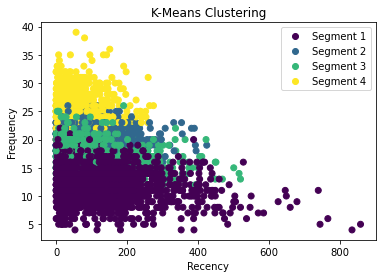

      Recency  Frequency     Monetary
0  114.093023  12.393186   566.396431
1   64.976345  20.596939  1444.696197
2   82.628234  16.362767  1075.155793
3   51.417722  25.845389  1853.824593
             Recency  Frequency  Monetary    Segment
customer_id                                         
CS1112            61         15      1012  Segment 3
CS1113            35         20      1490  Segment 2
CS1114            32         19      1432  Segment 2
CS1115            11         22      1659  Segment 4
CS1116           203         13       857  Segment 3
...              ...        ...       ...        ...
CS8996            97         13       582  Segment 1
CS8997           261         14       543  Segment 1
CS8998            84         13       624  Segment 1
CS8999           257         12       383  Segment 1
CS9000            16         13       533  Segment 1

[6889 rows x 4 columns]


In [21]:
X = rfm_data[['Recency', 'Frequency', 'Monetary']]

# Обучение модели K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(X)


scatter = plt.scatter(rfm_data['Recency'], rfm_data['Frequency'], c=rfm_data['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('K-Means Clustering')
legend_labels = ['Segment 1', 'Segment 2', 'Segment 3', 'Segment 4']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.show()

# Вывод средних значений каждого кластера
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])
print(cluster_centers)

# Присвоение меток сегментам
def assign_segment(cluster):
    if cluster == 0:
        return 'Segment 1'
    elif cluster == 1:
        return 'Segment 2'
    elif cluster == 2:
        return 'Segment 3'
    else:
        return 'Segment 4'

rfm_data['Segment'] = rfm_data['Cluster'].apply(assign_segment)


print(rfm_data[['Recency', 'Frequency', 'Monetary', 'Segment']])

Сегмент 1: имеет сравнительно большой Recency, то есть клиенты из этого сегмента давно не совершали покупкии крайне редко это делают (низкая Frequency), а также тратят мало денег (низкая Monetary). Возможно, такой сегмент клиентов сервисом больше пользуется

Сегмент 2: Recency меньше, что указывает на то, что клиенты недавно совершали покупки. Клиенты из этого сегмента совершают покупки средней частоты и тратят среднюю сумму денег.

Сегмент 3: низкий Recency, что может указывать на недавние покупки, но клиенты совершают меньше покупок и тратят меньше денег по сравнению с сегментом 2. Это может быть сегментом клиентов, которые вернулись, но еще не совершают много покупок.

Сегмент 4: низкий Recency, высокой Frequency и высокой Monetary. Это может быть сегментом высокодоходных клиентов, которые совершают частые и крупные покупки.
